# Reads preprocess
Raw reads from BYO-doped pool k-seq experiments were in `.fastq.gz` format and were preprocessed using `fastq-join` or `pandaSeq` to join pair-end reads, trim primers, and then survey counts for unique reads

### ilustration of pool evenness (mutation rate) to single resolution nt

In [2]:
from yuning_util.dev_mode import DevMode
dev_mode = DevMode('k-seq')
dev_mode.on()

from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 240

from k_seq.data import seq_table
SeqTable = seq_table.SeqTable

0.004048582995951417
0.021276595744680854
0.03296703296703297
0.045454545454545456
0.10526315789473684


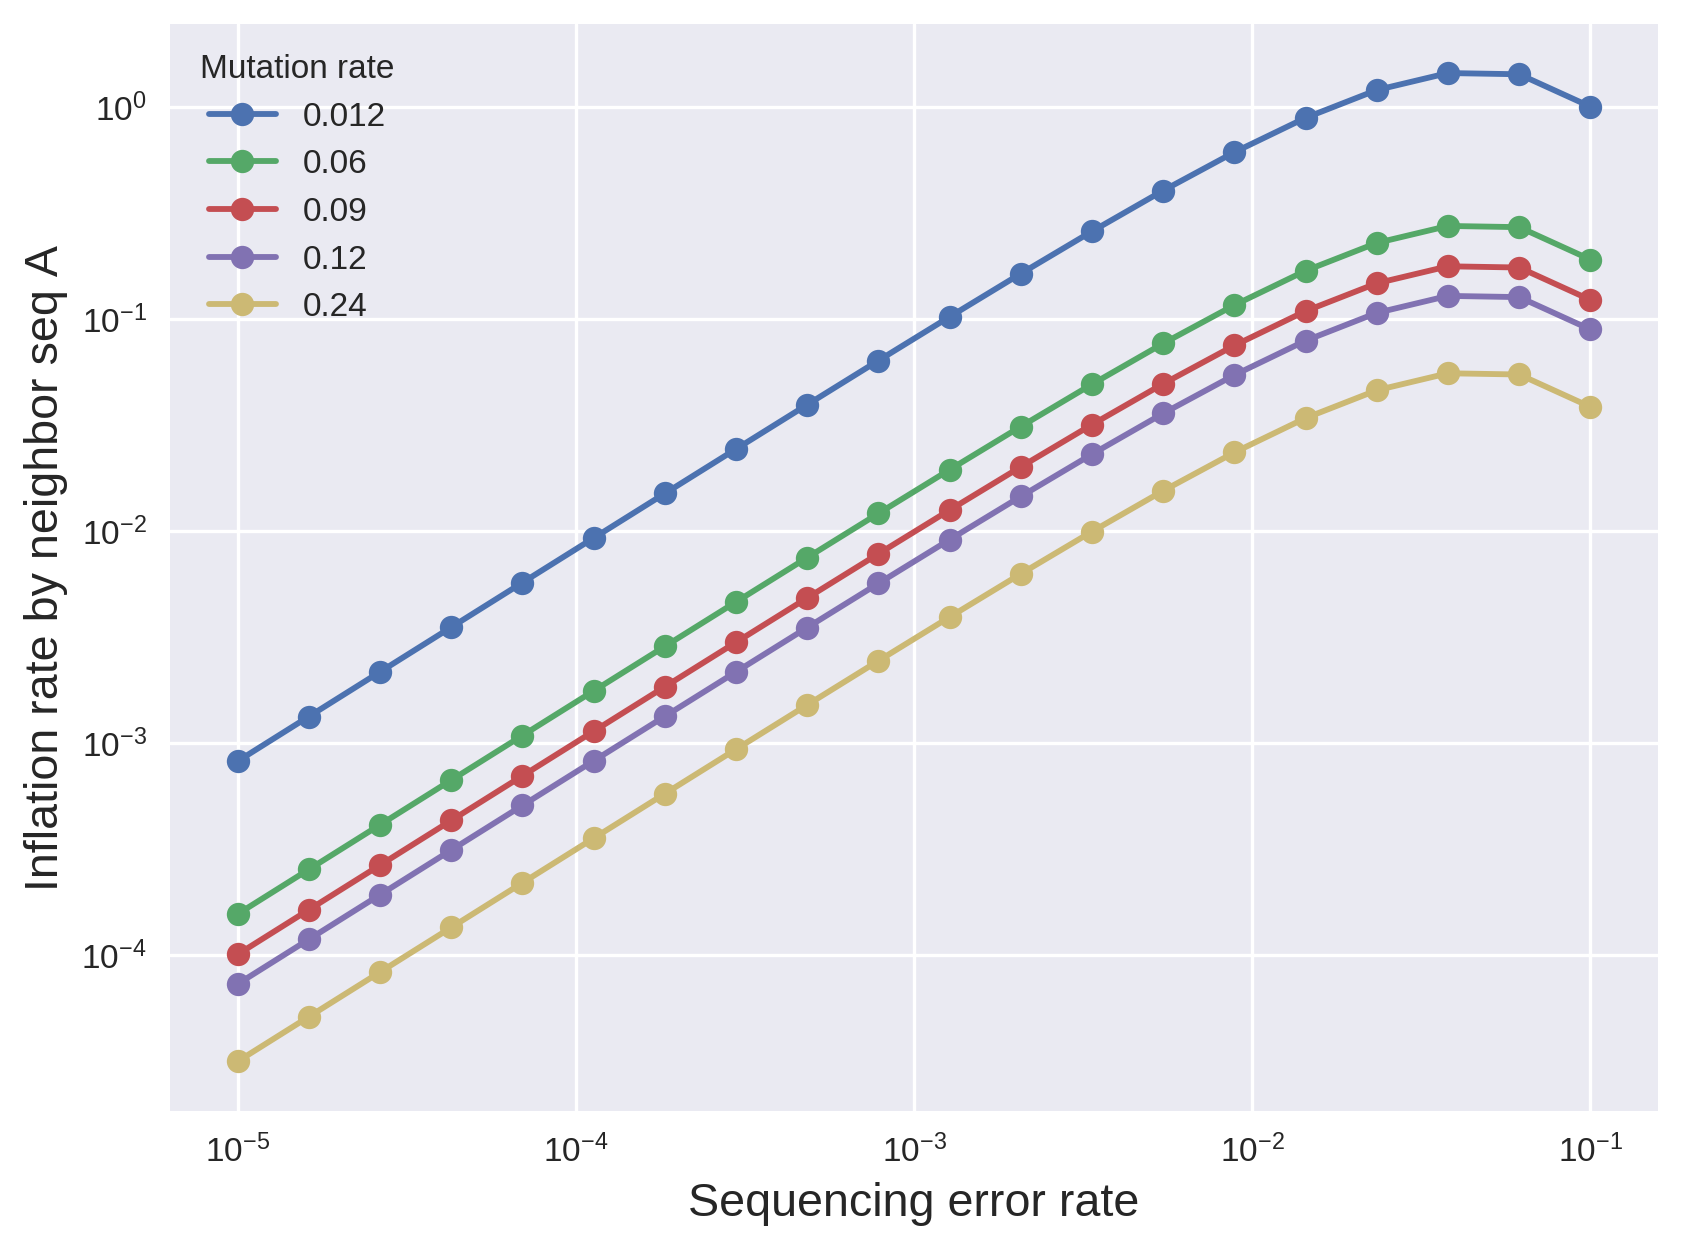

In [3]:
import numpy as np

muation_rate_list = [0.012, 0.06, 0.09, 0.12, 0.24]

seq_error = np.logspace(-5, -1, 20)
L = 21
fig, ax = plt.subplots(1, 1, figsize=[8, 6])

for mutation_rate in muation_rate_list:
    gamma = mutation_rate / 3 / (1 - mutation_rate)
    print(gamma)
    pct_infl = seq_error * (1 - seq_error)**20 / 3 / gamma
    ax.plot(seq_error, pct_infl, marker='o', label=mutation_rate)

ax.set_xscale('log')
ax.set_xlabel('Sequencing error rate', fontsize=14)
ax.set_ylabel('Inflation rate by neighbor seq A', fontsize=14)
ax.set_yscale('log')
ax.legend(title='Mutation rate')
plt.show()

## Repeat seq_table processing pipeline through pandaSeq joined sequence
** Only run it when need to recreate the dataset 

In [4]:
runs = ['allow-mismatch', 'no-mismatch',
        'allow-mismatch-assembly-first', 'no-mismatch-assembly-first']

for run in runs:
    seq_table = SeqTable.load_dataset(dataset='byo-doped', from_count_file=True,
                          count_file_path=f'/mnt/storage/projects/k-seq/working/byo_doped/read_join/{run}/counts/',
                          pandaseq_joined=True)
    seq_table.to_pickle(f'/mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/{run}.pkl')

TypeError: _load_byo_doped() got an unexpected keyword argument 'pandaseq_joined'

## Sample level analysis

Here we look into sample level analysis on different joining methods, typically what is the passing ratio of total reads and number of uniques sequences, in the process of
- Joining
- Sequence length and spike-in filtering
- Reacted fraction calculation

### Load results
We load in following 

1. raw reads

2. joined reads in various methods (== seq_table.table)

3. seq_table.table_filtered in various methods

4. seq_table.table_filtered_reacted_frac in various methods (recover the counts from index sequences)

In [3]:
from k_seq.utility.func_tools import AttrScope
from k_seq.data.seq_table import SeqTable
reload(seq_table)

reads = AttrScope(raw_reads=None,
                  joined_total=None, joined_unique=None,
                  filtered_total=None, filtered_unique=None,
                  valid_total=None, valid_unique=None)

In [10]:
def get_total_and_unique(table):
    return table.sum(axis=0), (table > 0).sum(axis=0)

def rename_res(name):
    """Rename results loaded from raw reads and samples as
    
    A1/d-A1_S1 --> 1250uM-1
    ...
    R/R0 --> input
    """
    
    if len(name) > 2:
        name = name.split('_')[0].split('-')[-1]
    
    if 'R' in name:
        return 'Input'
    else:
        concen_mapper = {
            'A': '1250',
            'B': '250',
            'C': '50',
            'D': '10',
            'E': '2'
        }
        return "{} $\mu M$-{}".format(concen_mapper[name[0]], name[1])

# add raw reads
raw_reads = pd.read_csv('/mnt/storage/projects/k-seq/input/byo_doped/raw_reads/sample_reads.tsv', sep='\t')
sample_reads = raw_reads[raw_reads['R'] == 1].groupby('file').sum()
reads.raw_reads = sample_reads['reads'].rename(rename_res)
reads.raw_reads.index.name = 'sample'
reads.raw_reads.name = 'raw_reads'

methods = ['fastq-join', 'allow-mismatch', 'no-mismatch',
           'allow-mismatch-assembly-first', 'no-mismatch-assembly-first']

# load fastq-joined
seq_table = SeqTable.load_dataset('byo-doped')
total, unique = get_total_and_unique(seq_table.table)
reads.joined_total = pd.DataFrame({'fastq-join': total})
reads.joined_unique = pd.DataFrame({'fastq-join': unique})
total, unique = get_total_and_unique(seq_table.table_filtered)
reads.filtered_total = pd.DataFrame({'fastq-join': total})
reads.filtered_unique = pd.DataFrame({'fastq-join': unique})
total, unique = get_total_and_unique(seq_table.table.loc[seq_table.table_filtered_reacted_frac_spike_in.index])
reads.valid_total = pd.DataFrame({'fastq-join': total})
reads.valid_unique = pd.DataFrame({'fastq-join': unique})

# load pandaSeq results
for run in methods[1:]:
    seq_table = SeqTable.load_dataset(
        'byo-doped',
        pickled_path=f'/mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/{run}.pkl'
    )

    reads.joined_total[run], reads.joined_unique[run] = get_total_and_unique(seq_table.table)
    reads.filtered_total[run], reads.filtered_unique[run] = get_total_and_unique(seq_table.table_filtered)
    reads.valid_total[run], reads.valid_unique[run] = get_total_and_unique(seq_table.table.loc[seq_table.table_filtered_reacted_frac_spike_in.index])


Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped.pkl
Imported!
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/allow-mismatch.pkl
Imported!
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/no-mismatch.pkl
Imported!
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/allow-mismatch-assembly-first.pkl
Imported!
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/no-mismatch-assembly-first.pkl
Imported!


# pandaSeq joined `no-mismatch-join-first` analysis

## Total reads from samples 

/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/bin/ipython:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  # -*- coding: utf-8 -*-


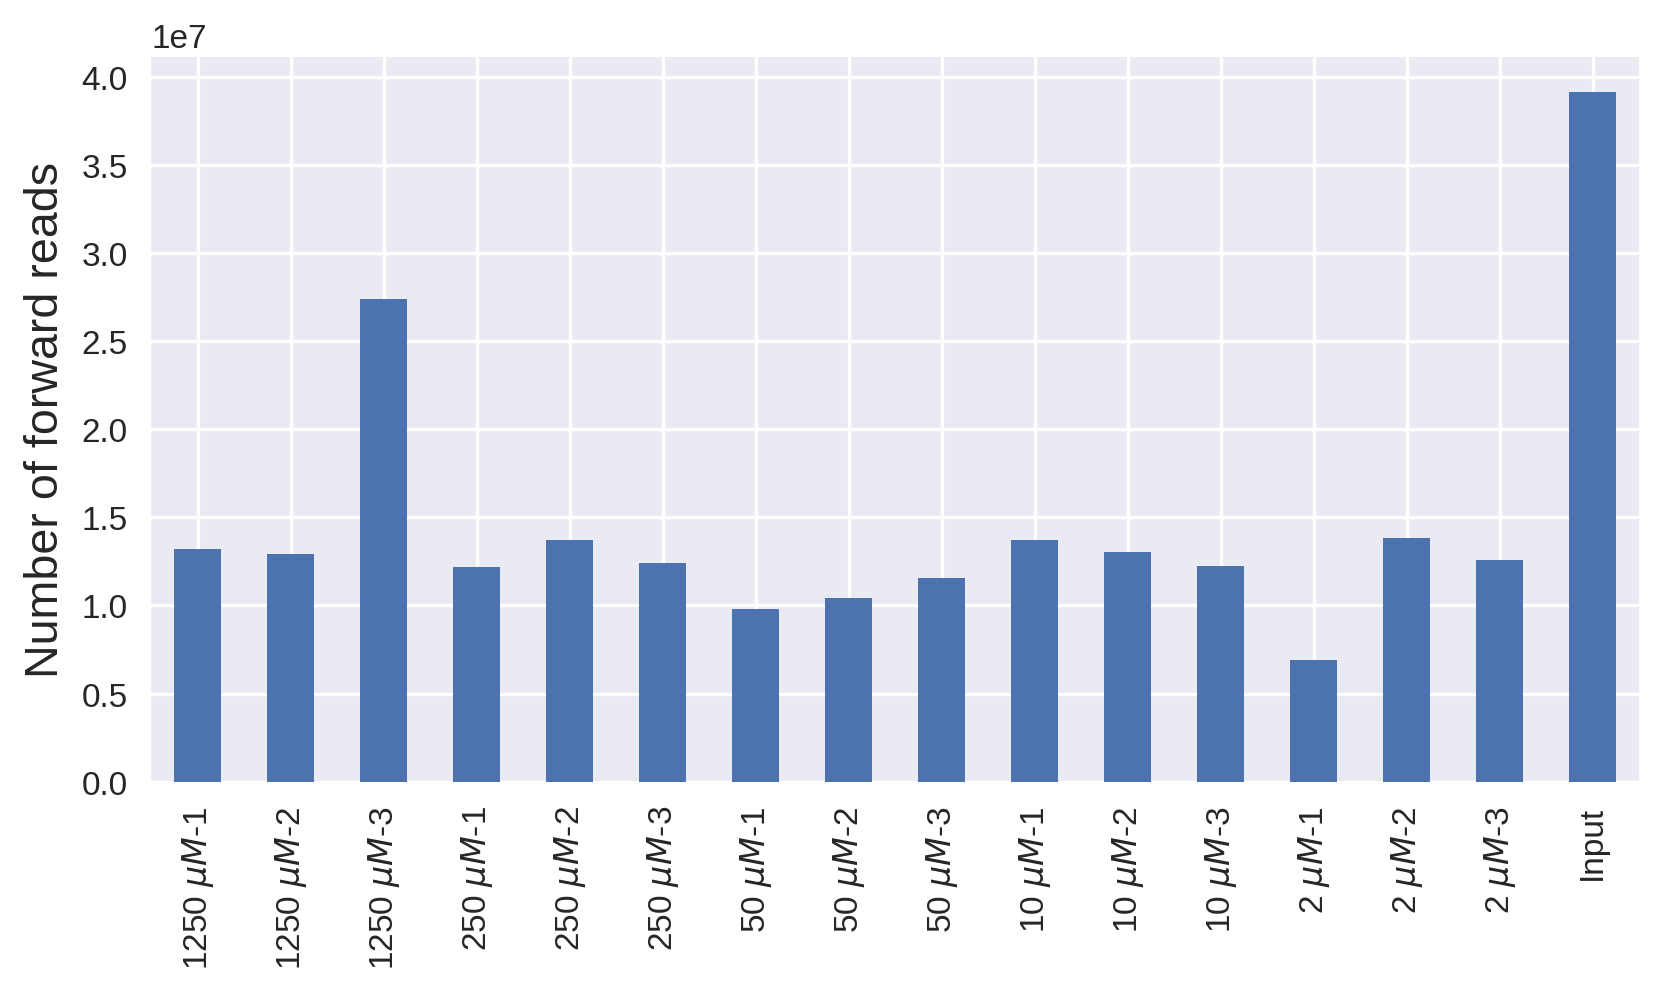

In [9]:
fig = plt.figure(figsize=(8, 4))
ax = reads.raw_reads.plot('bar')
ax.set_ylabel('Number of forward reads', fontsize=14)
ax.set_xlabel('')
plt.show()

## Joining / filtering / valid sequence ratio

In [8]:
reads.filtered_total.rename(index=rename_res)

fastq-join  allow-mismatch  no-mismatch  \
1250 $\mu M$-1    11506274        12102026     11762742   
1250 $\mu M$-2    11316293        11894724     11566580   
1250 $\mu M$-3    24015945        25300152     24560533   
250 $\mu M$-1     10755817        11284615     10993051   
250 $\mu M$-2     12147619        12738935     12415671   
250 $\mu M$-3     10971782        11531304     11222101   
50 $\mu M$-1       8632529         9070692      8824458   
50 $\mu M$-2       9211941         9671262      9416693   
50 $\mu M$-3      10192230        10737142     10428922   
10 $\mu M$-1      12087387        12688111     12355069   
10 $\mu M$-2      11540248        12104958     11794513   
10 $\mu M$-3      10748261        11350046     11011670   
2 $\mu M$-1        6087294         6382954      6219666   
2 $\mu M$-2       12359886        12949456     12631749   
2 $\mu M$-3       11135177        11712817     11397519   
Input             32931916        34800809     33690371   

                allow-mismatch-assembly-first  no-mismatch-assembly-first  
1250 $\mu M$-1                       12140691                    11506274  
1250 $\mu M$-2                       11915208                    11316293  
1250 $\mu M$-3                       25400496                    24015945  
250 $\mu M$-1                        11287562                    10755817  
250 $\mu M$-2                        12727350                    12147619  
250 $\mu M$-3                        11530567                    10971782  
50 $\mu M$-1                          9085639                     8632529  
50 $\mu M$-2                          9674498                     9211941  
50 $\mu M$-3                         10755414                    10192230  
10 $\mu M$-1                         12690899                    12087387  
10 $\mu M$-2                         12091672                    11540248  
10 $\mu M$-3                         11353709                    10748261  
2 $\mu M$-1                           6379364                     6087294  
2 $\mu M$-2                          12926600                    12359886  
2 $\mu M$-3                          11694902                    11135177  
Input                                34949713                    32931916

A1    12004474
A2    11752226
A3    24822840
B1    11116634
B2    12552203
B3    11352810
C1     8935891
C2     9571053
C3    10536759
D1    12523217
D2    11964168
D3    11130979
E1     6318649
E2    12735443
E3    11487021
R0    35230243
Name: no-mismatch-assembly-first, dtype: int64

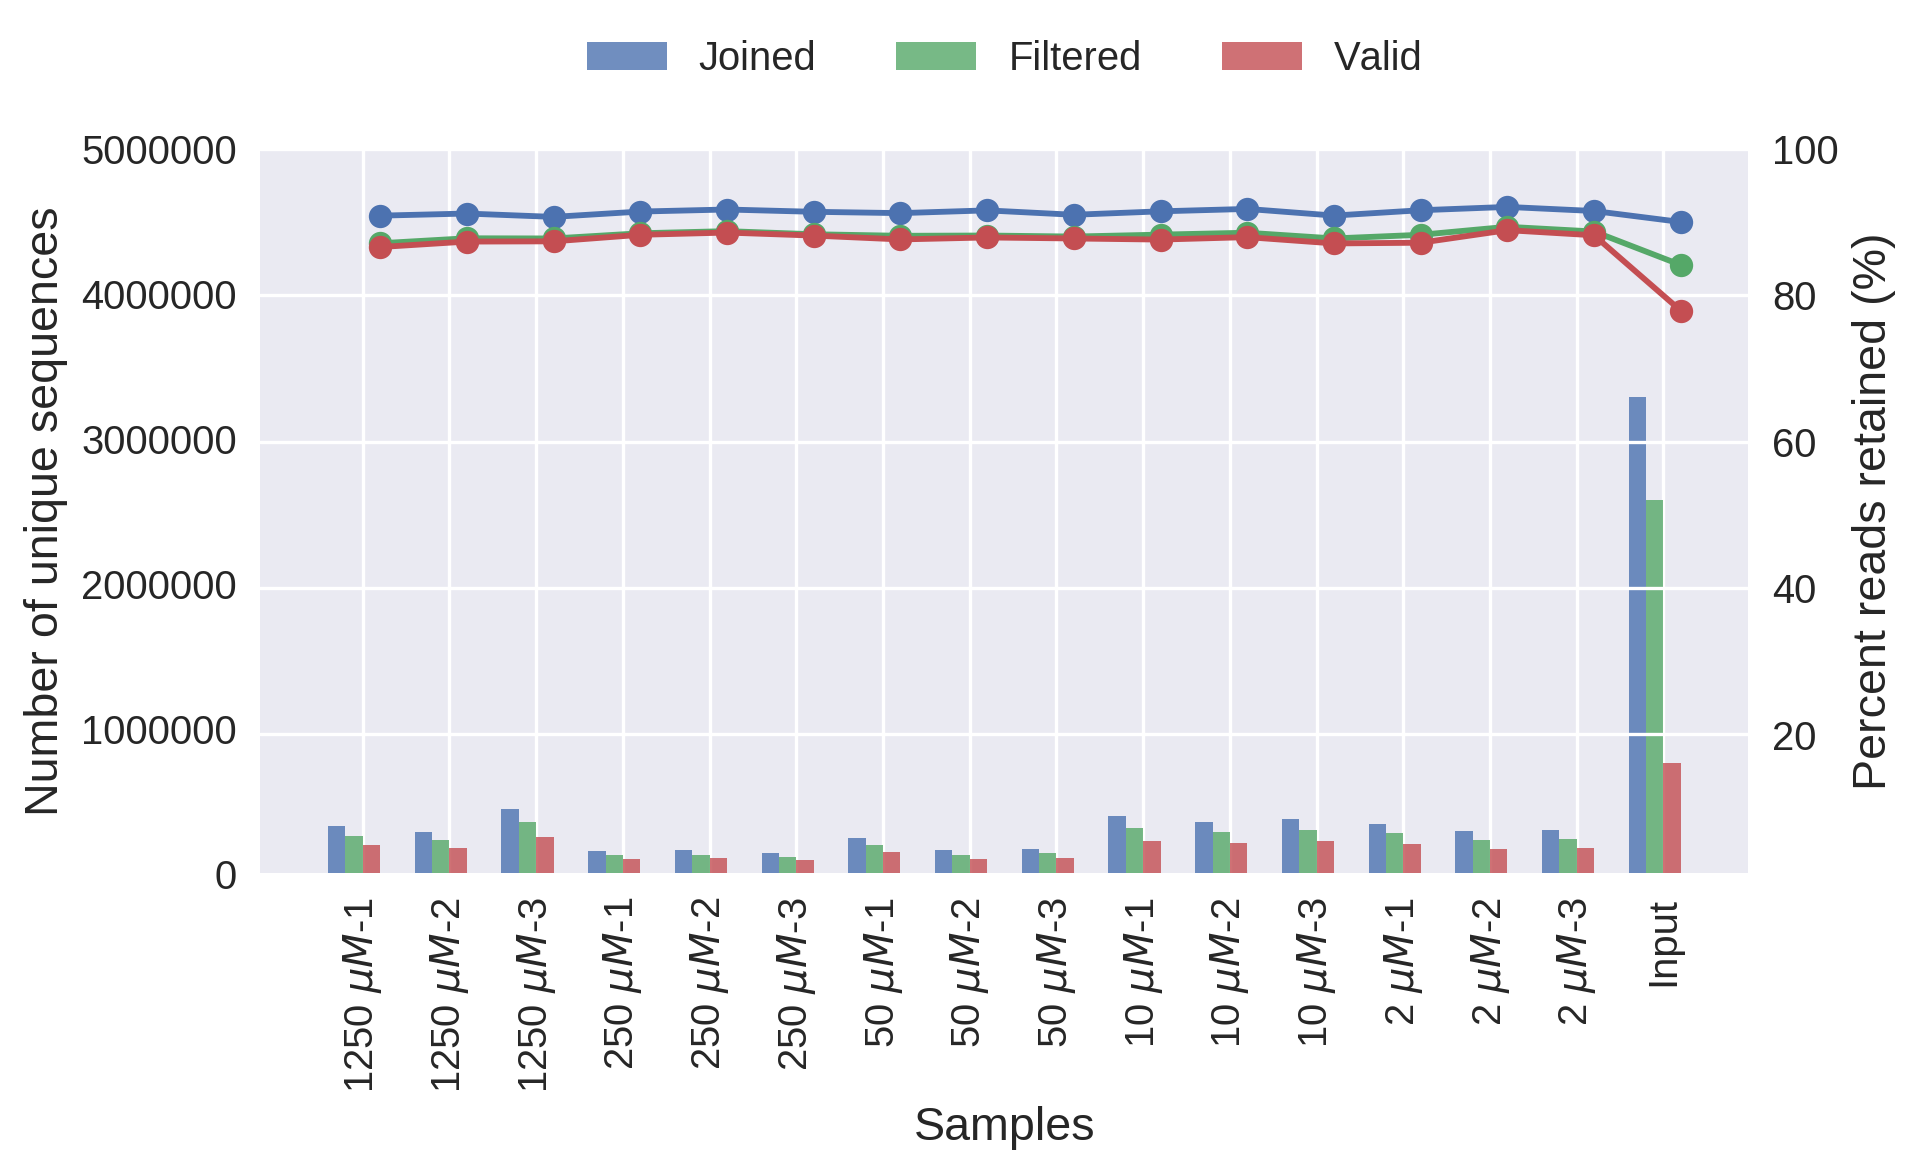

In [19]:
stages = ['joined', 'filtered', 'valid']

fig, ax = plt.subplots(1, 1, figsize=[8, 4])
pos = np.arange(reads.filtered_total.shape[0]) * (len(stages) + 2)

ax1 = ax.twinx()

# Barplot for unique sequences
for ix, stage in enumerate(stages):
    x = pos + ix + 1
    y = getattr(reads, stage + '_unique')['no-mismatch-assembly-first']
    y = y.rename(index=rename_res)
    ax.bar(x=x, height=y, width=1, align='center', label=stage.title(), alpha=0.8, zorder=1)

ax.set_ylabel('Number of unique sequences', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim([0, 5_000_000])
ax.grid(axis='y', b=None, which='both')

# plot for joined ratio (total reads)
x = pos + 1 + len(stage) / 2
for stage in stages:
    joined_ratio = getattr(reads, stage + '_total')['no-mismatch-assembly-first'].rename(index=rename_res).divide(reads.raw_reads, axis=0) * 100
    ax1.plot(x, joined_ratio, marker='o', zorder=10)
ax1.set_ylabel('Percent reads retained (%)', fontsize=14)
ax1.set_ylim([1, 100])
ax1.tick_params(labelsize=12)


ax.set_xticks(pos + 1 + len(stages) / 2)
ax.set_xticklabels(joined_ratio.index.values, fontsize=12, rotation=90)
ax.set_xlabel('Samples', fontsize=14)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize=12)

plt.show()

### Pair-end reads joining process

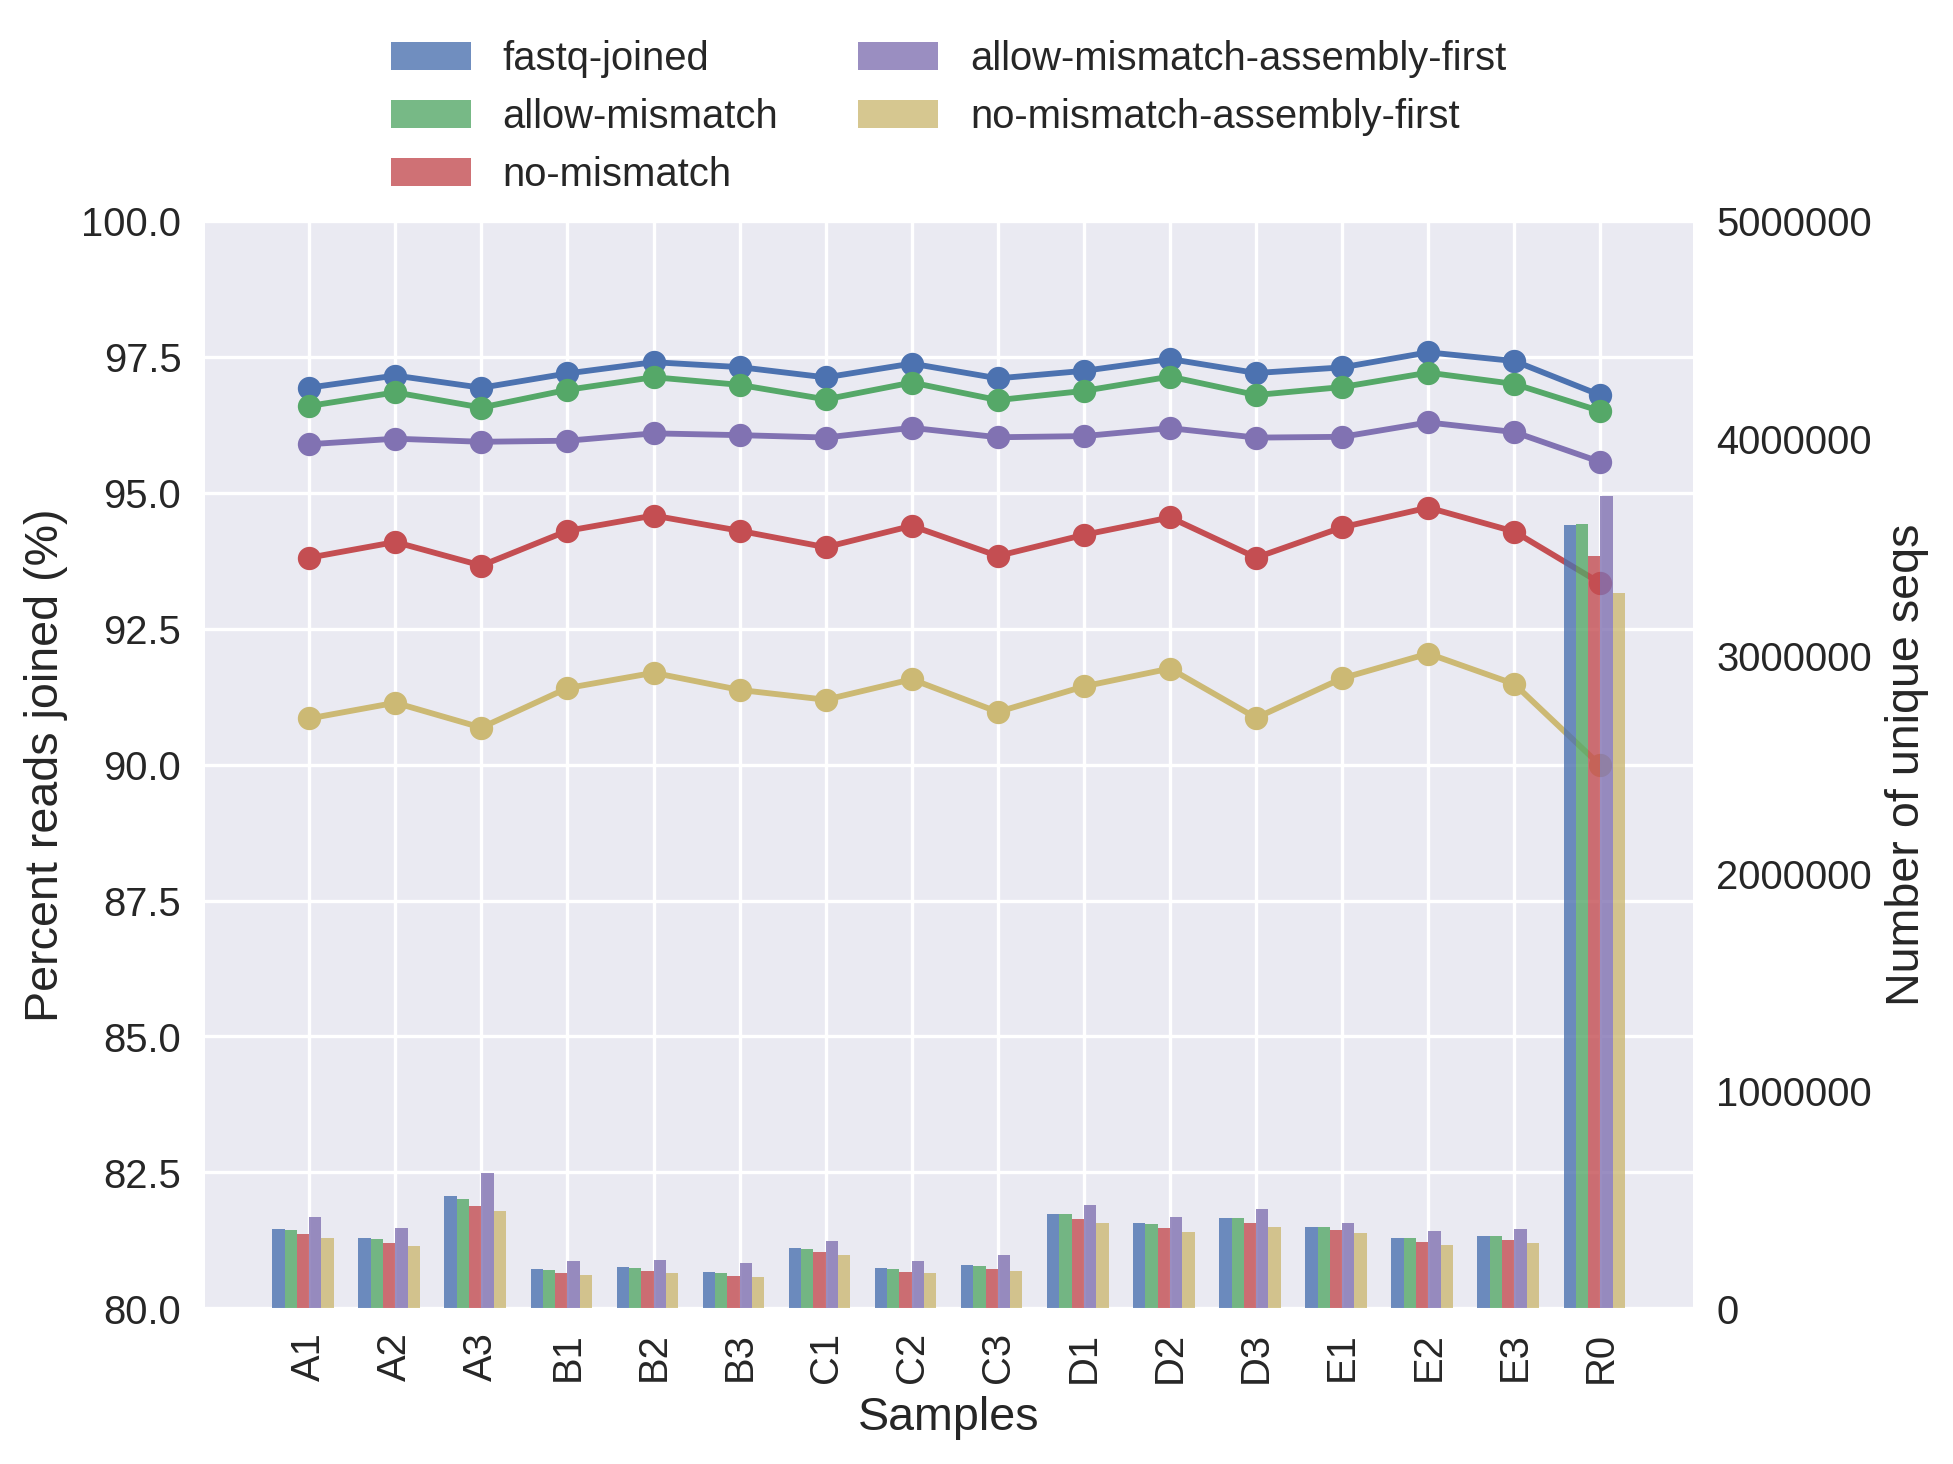

In [277]:


fig, ax = plt.subplots(1, 1, figsize=[8, 6])
pos = np.arange(joined_ratio.shape[0]) * (len(methods) + 2)

ax1 = ax.twinx()

# Barplot for unique sequences
for ix, method in enumerate(methods):
    x = pos + ix + 1
    y = reads.joined_unique[method]
    ax1.bar(x=x, height=y, width=1, align='center', label=method, alpha=0.8, zorder=1)
ax1.set_ylabel('Number of unique seqs', fontsize=14)
ax1.tick_params(labelsize=12)
ax1.set_ylim([0, 5_000_000])
ax1.grid(axis='y', b=None, which='both')

# plot for joined ratio (total reads)
joined_ratio = reads.joined_total.divide(reads.raw_reads, axis=0) * 100

x = pos + 1 + len(methods) / 2
for method in methods:
    ax.plot(x, joined_ratio[method], marker='o', zorder=10)
ax.set_ylabel('Percent reads joined (%)', fontsize=14)
ax.set_ylim([80, 100])
ax.tick_params(labelsize=12)


ax.set_xticks(pos + 1 + len(methods) / 2)
ax.set_xticklabels(joined_ratio.index.values, fontsize=12, rotation=90)
ax.set_xlabel('Samples', fontsize=14)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=12)

plt.show()n

### Filtering: remove spike-in and sequence != 21 nt

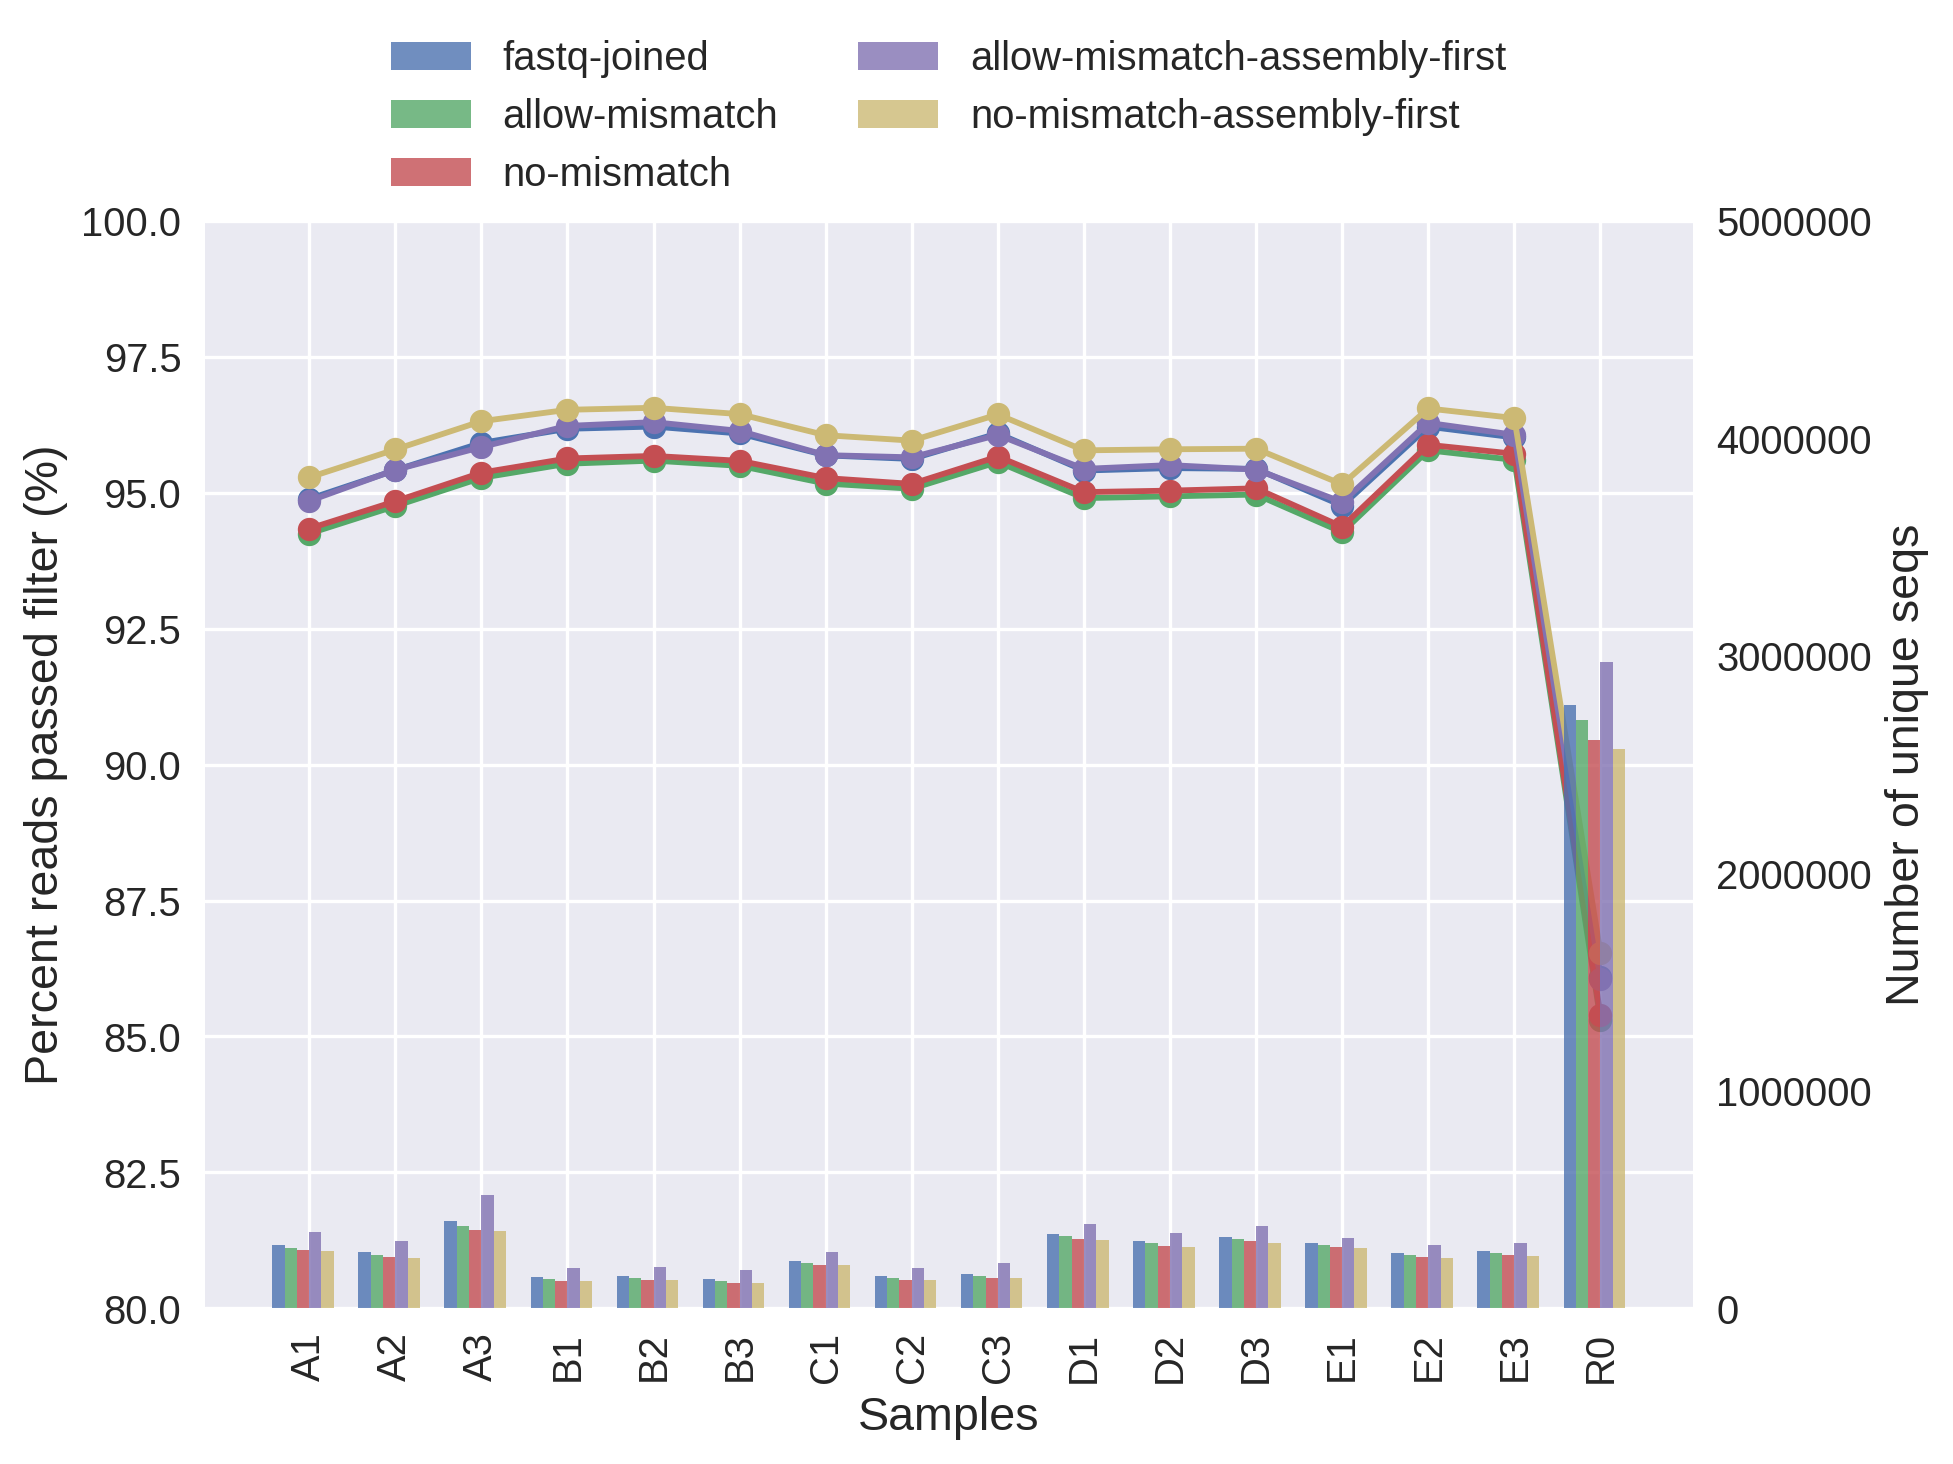

In [278]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
pos = np.arange(reads.filtered_total.shape[0]) * (len(methods) + 2)

ax1 = ax.twinx()

# Barplot for unique sequences
for ix, method in enumerate(methods):
    x = pos + ix + 1
    y = reads.filtered_unique[method]
    ax1.bar(x=x, height=y, width=1, align='center', label=method, alpha=0.8, zorder=1)
ax1.set_ylabel('Number of unique seqs', fontsize=14)
ax1.tick_params(labelsize=12)
ax1.set_ylim([0, 5_000_000])
ax1.grid(axis='y', b=None, which='both')

# plot for joined ratio (total reads)
pass_ratio = reads.valid_total.divide(reads.joined_total) * 100

x = pos + 1 + len(methods) / 2
for method in methods:
    ax.plot(x, pass_ratio[method], marker='o', zorder=10)
ax.set_ylabel('Percent reads passed filter (%)', fontsize=14)
ax.set_ylim([80, 100])
ax.tick_params(labelsize=12)

ax.set_xticks(pos + 1 + len(methods) / 2)
ax.set_xticklabels(pass_ratio.index.values, fontsize=12, rotation=90)
ax.set_xlabel('Samples', fontsize=14)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=12)

plt.show()

### Valid sequences

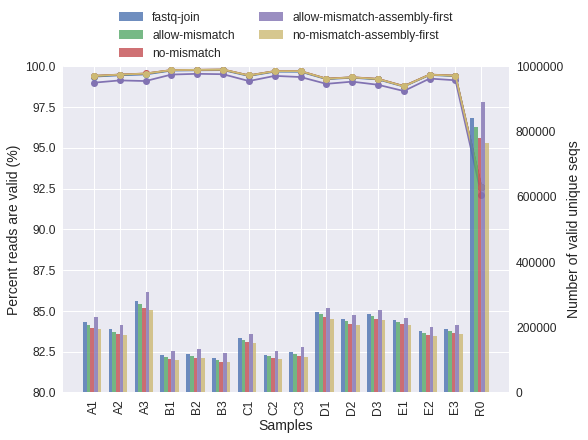

In [12]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
pos = np.arange(reads.filtered_total.shape[0]) * (len(methods) + 2)

ax1 = ax.twinx()

# Barplot for unique sequences
for ix, method in enumerate(methods):
    x = pos + ix + 1
    y = reads.valid_unique[method]
    ax1.bar(x=x, height=y, width=1, align='center', label=method, alpha=0.8, zorder=1)
ax1.set_ylabel('Number of valid unique seqs', fontsize=14)
ax1.tick_params(labelsize=12)
ax1.set_ylim([0, 1_000_000])
ax1.grid(axis='y', b=None, which='both')

# plot for joined ratio (total reads)
valid_ratio = reads.valid_total.divide(reads.filtered_total) * 100

x = pos + 1 + len(methods) / 2
for method in methods:
    ax.plot(x, valid_ratio[method], marker='o', zorder=10)
ax.set_ylabel('Percent reads are valid (%)', fontsize=14)
ax.set_ylim([80, 100])
ax.tick_params(labelsize=12)


ax.set_xticks(pos + 1 + len(methods) / 2)
ax.set_xticklabels(valid_ratio.index.values, fontsize=12, rotation=90)
ax.set_xlabel('Samples', fontsize=14)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=12)

plt.show()

### Summarize: from joined sequences to valid sequences

In [29]:
from k_seq.data.seq_table import SeqTable

def get_series(method):
    print(f'Load {method}')
    if method == 'fastq-join':
        seq_table = SeqTable.load_dataset('byo-doped')
    else:
        seq_table = SeqTable.load_dataset(
            'byo-doped',
            pickled_path=f'/mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/{method}.pkl'
        )
    valid_table = seq_table.table.loc[seq_table.table_filtered_reacted_frac_spike_in.index.values]
    all_valid_table = seq_table.table.loc[seq_table.table_filtered_seq_in_all_smpl_reacted_frac_spike_in.index.values]
    
    return {
        'Joined': seq_table.table.sum().sum(),
        'Filtered': seq_table.table_filtered.sum().sum(),
        'Valid': valid_table.sum().sum(),
        'In all samples': all_valid_table.sum().sum(),
    }, {
        'Joined': seq_table.table.shape[0],
        'Filtered': seq_table.table_filtered.shape[0],
        'Valid': valid_table.shape[0],
        'In all samples': all_valid_table.shape[0],
    }

In [33]:
total_reads = {}
unique_seqs = {}
for method in methods:
    total_reads[method], unique_seqs[method] = get_series(method)

Load fastq-join
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped.pkl
Imported!
Load allow-mismatch
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/allow-mismatch.pkl
Imported!
Load no-mismatch
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/no-mismatch.pkl
Imported!
Load allow-mismatch-assembly-first
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/allow-mismatch-assembly-first.pkl
Imported!
Load no-mismatch-assembly-first
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/no-mismatch-assembly-first.pkl
Imported!


In [36]:
total_reads = pd.DataFrame(total_reads) / reads.raw_reads.sum(0) * 100
unique_seqs = pd.DataFrame(unique_seqs)

In [38]:
total_reads

fastq-join  allow-mismatch  no-mismatch  \
Joined           97.156690       96.812872    94.021955   
Filtered         92.989251       92.042988    89.477811   
Valid            91.460241       90.559641    88.045735   
In all samples   86.894720       86.082187    83.742435   

                allow-mismatch-assembly-first  no-mismatch-assembly-first  
Joined                              95.969774                   91.070566  
Filtered                            92.163948                   87.498960  
Valid                               90.349626                   86.087940  
In all samples                      85.659078                   81.871574

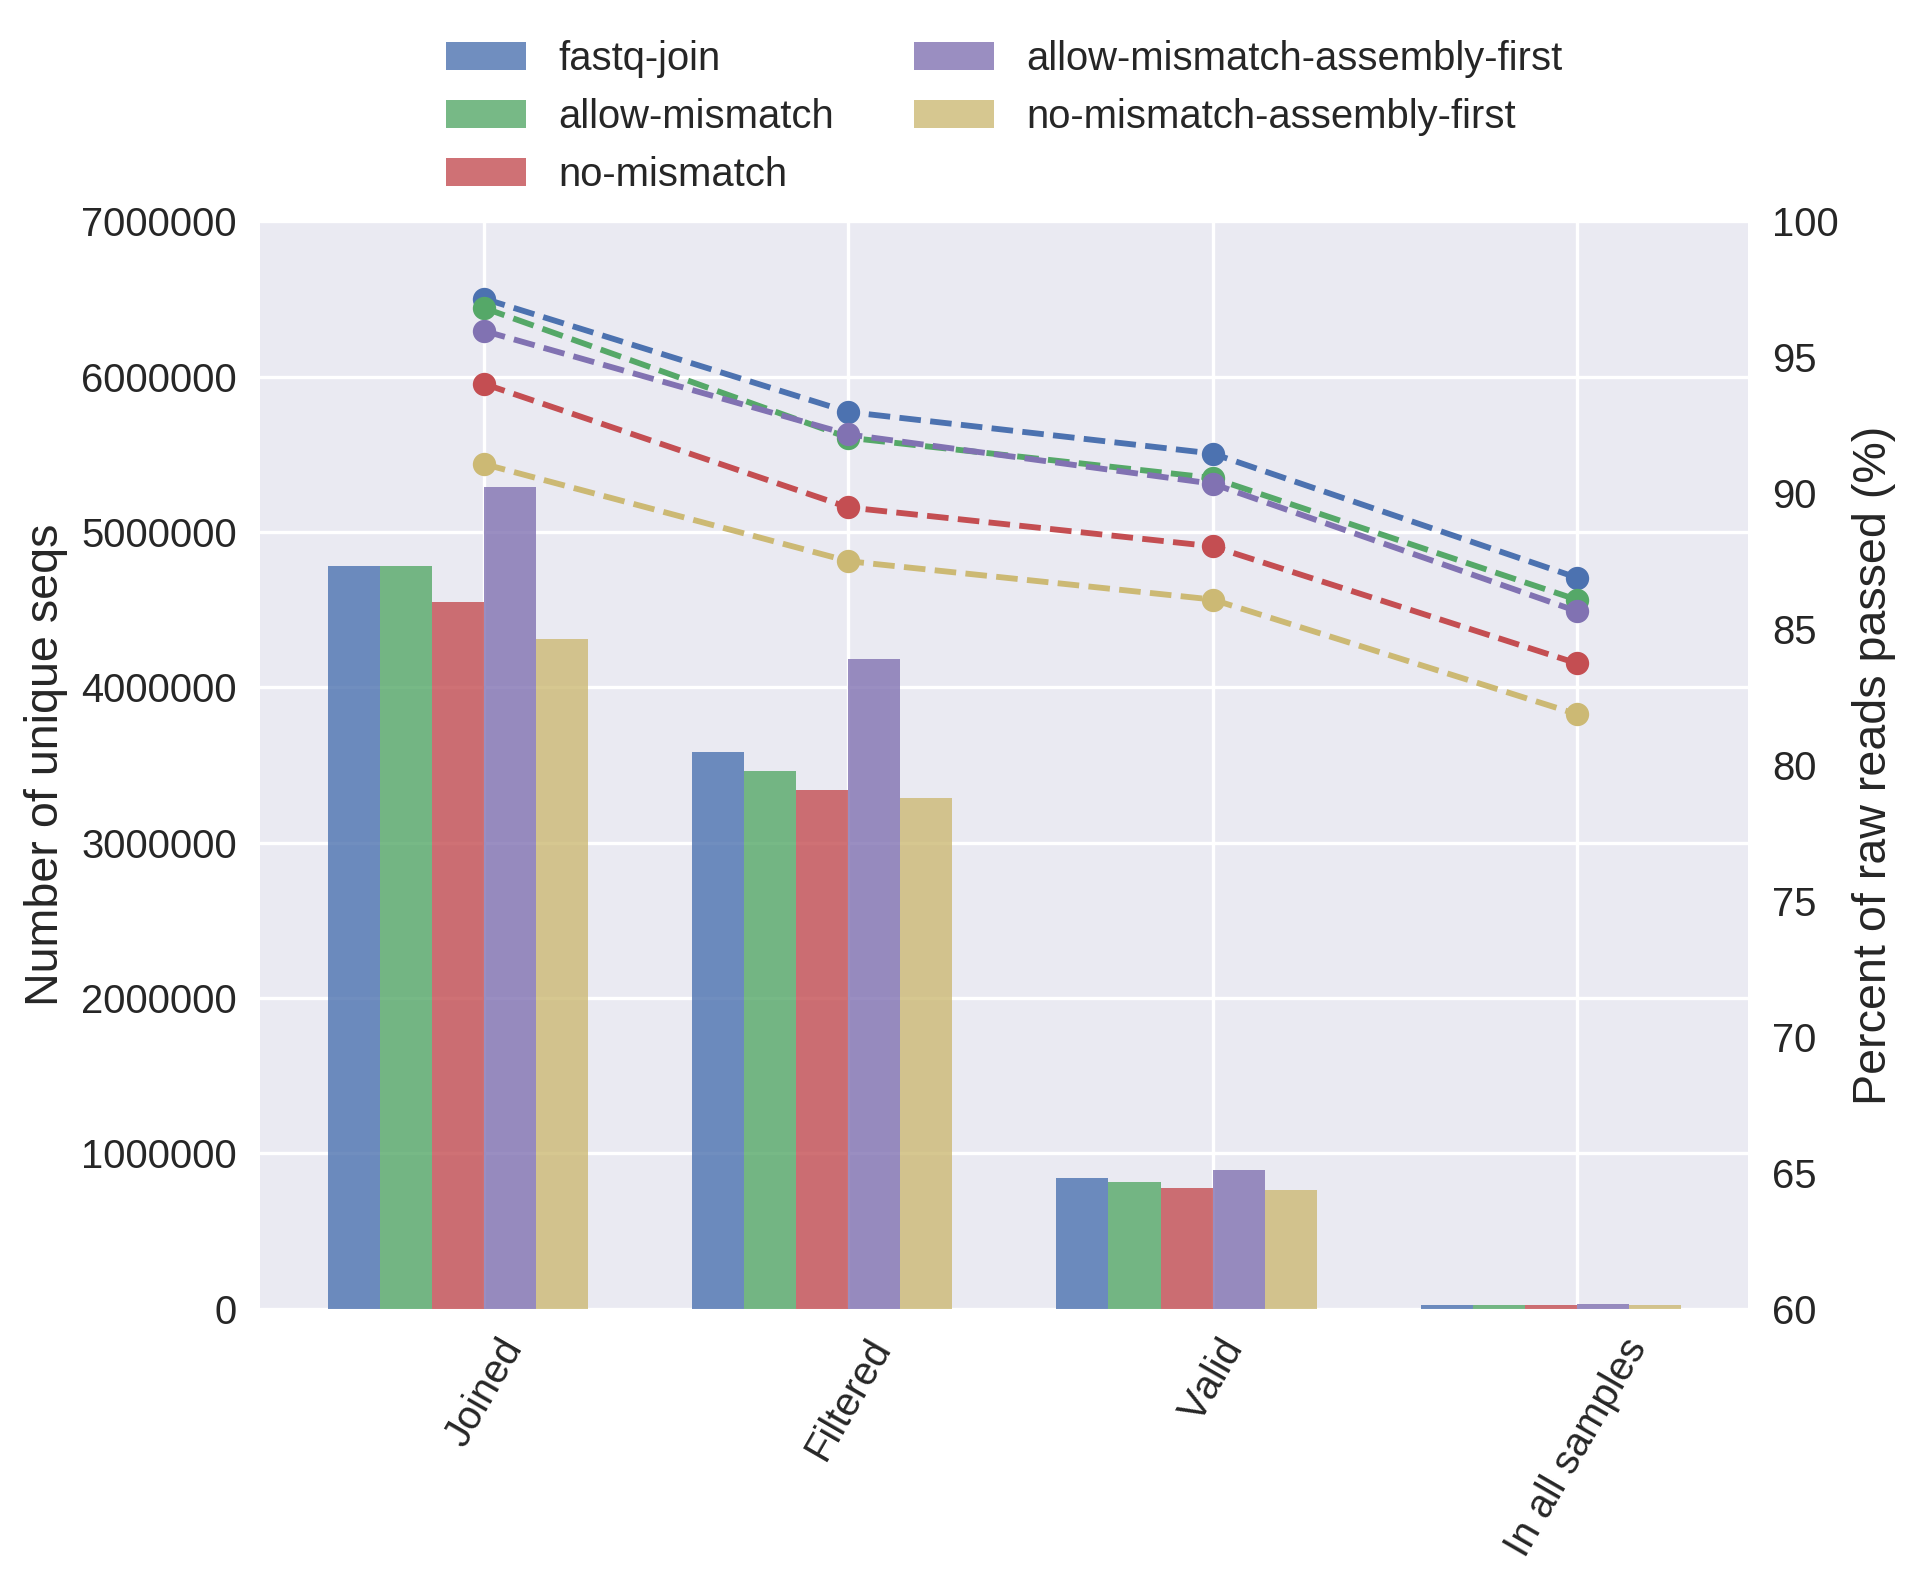

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax1 = ax.twinx()

pos = np.arange(total_reads.shape[0]) * (len(methods) + 2)

# Barplot for unique sequences
for ix, method in enumerate(methods):
    x = pos + ix + 1
    y = unique_seqs[method]
    ax.bar(x=x, height=y, width=1, align='center', label=method, alpha=0.8, zorder=1)
ax.set_ylabel('Number of unique seqs', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim([0, 7_000_000])

# plot for joined  (total reads)
x = pos + 1 + len(methods) / 2
for method in methods:
    ax1.plot(x, total_reads[method], marker='o', ls='--', zorder=10)
ax1.set_ylabel('Percent of raw reads passed (%)', fontsize=14)
ax1.set_ylim([60, 100])
ax1.grid(axis='y', b=None, which='both')
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=12)


ax.set_xticks(pos + 1 + len(methods) / 2)
ax.set_xticklabels(total_reads.index.values, fontsize=12, rotation=60)
# ax.set_xlabel('Samples', fontsize=14)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=12)

plt.show()

## Sequence level analysis
We analyze at sequence level that to see what is the variance of reacted fraction for each sequence when using different joining methods

We use `fastq-join` results as baseline, compare the percent difference:
    
    (reacted_frac_method - reacted_frac_fastq-join) / react_frac_fastq-join
    
and we organize them by samples.

As the quantification here if same when using total DNA amount, (which might be different when using spike-in as it depends on the actual spike-in seqs get), the reacted fraction ratio calculated is equavalent as relative abundance; thus, we use total DNA quantified results

In [3]:
base_seq_table = SeqTable.load_dataset('byo-doped')
base_counts = base_seq_table.table['R0']
base_seq_table = base_seq_table.table_filtered_reacted_frac_total_dna

Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped.pkl
Imported!


In [4]:
methods = ['fastq-join', 'allow-mismatch', 'no-mismatch',
           'allow-mismatch-assembly-first', 'no-mismatch-assembly-first']
compared_table = {}
for method in methods[1:]:
    compared_table[method] = SeqTable.load_dataset(
        'byo-doped',
        pickled_path=f'/mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/{method}.pkl'
    ).table_filtered_reacted_frac_total_dna

Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/allow-mismatch.pkl
Imported!
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/no-mismatch.pkl
Imported!
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/allow-mismatch-assembly-first.pkl
Imported!
Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq/no-mismatch-assembly-first.pkl
Imported!


/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/pandas/core/indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


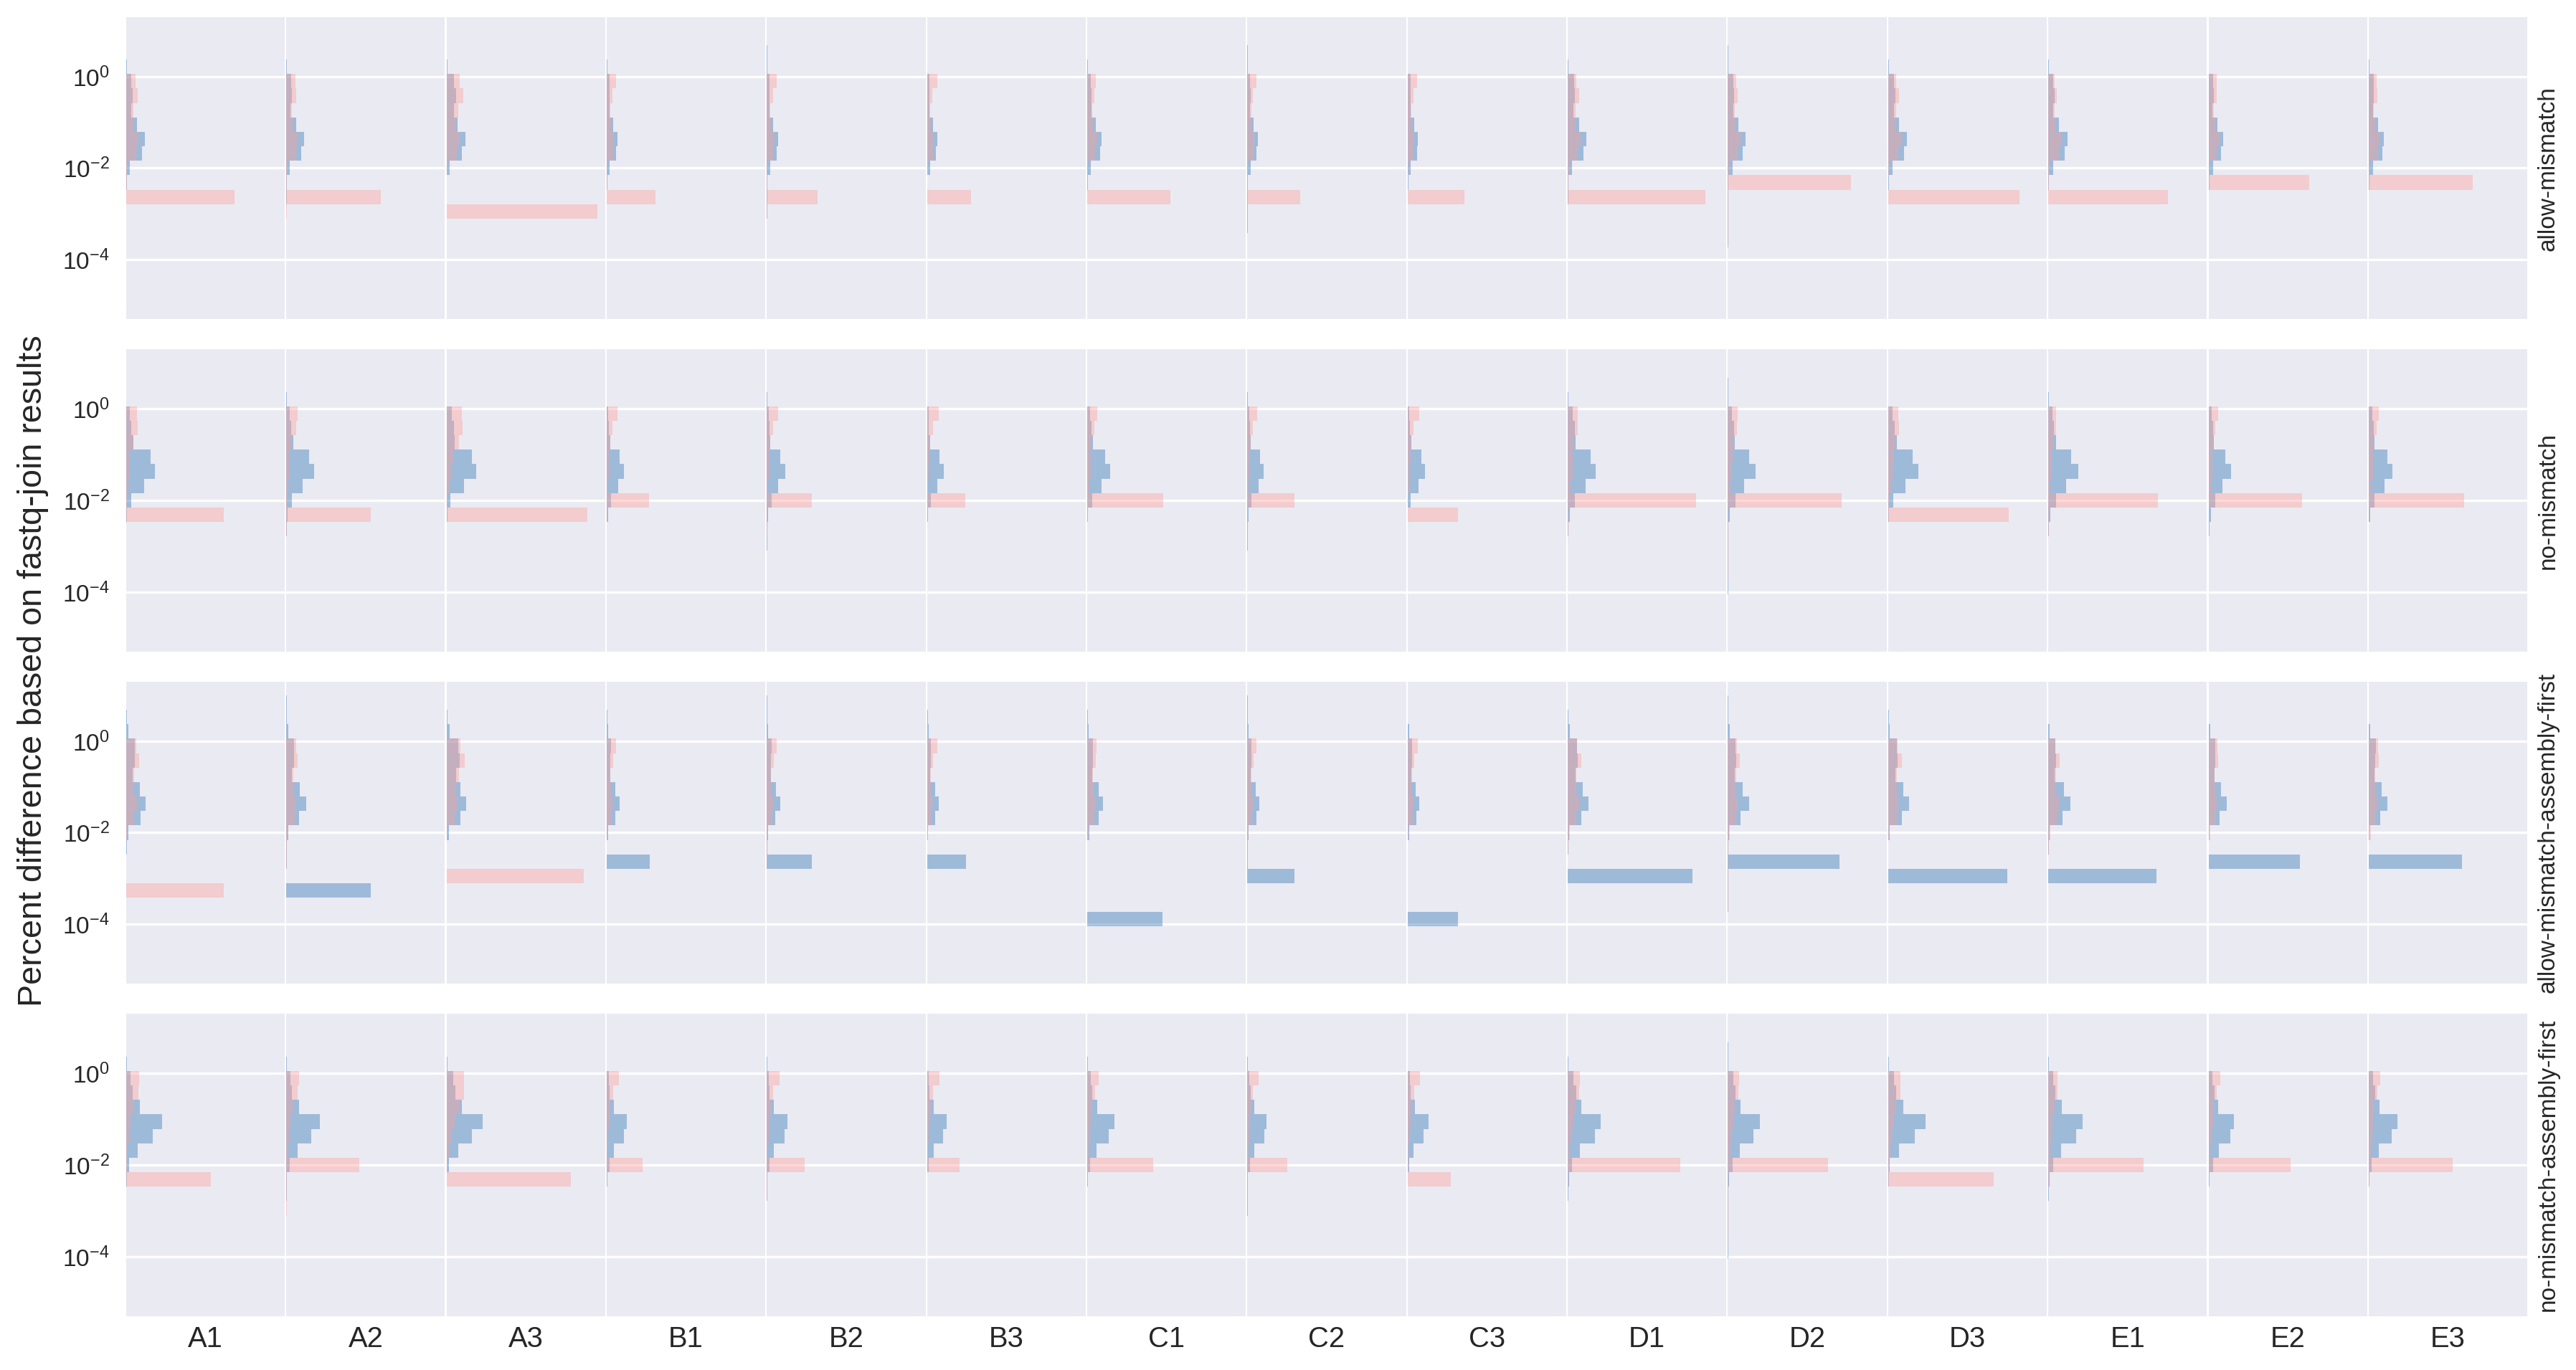

In [113]:
sample_list = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3',
               'C1', 'C2', 'C3', 'D1', 'D2', 'D3', 'E1', 'E2', 'E3']
fig, axes = plt.subplots(4, 15, figsize=(18, 10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.1, wspace=0.01)
bins = np.logspace(-5, 1, 20)

for ax_row, method in zip(axes, methods[1:]):
    common_seq = base_seq_table.index[base_seq_table.index.isin(compared_table[method].index)]
    pct_diff = compared_table[method].reindex(common_seq) / base_seq_table.reindex(common_seq) - 1
    for ax, sample in zip(ax_row, sample_list):
        ax.hist(pct_diff[sample][pct_diff[sample] > 0], bins=bins,
                color='#2C73B4', alpha=0.4, orientation='horizontal')
        ax.hist(-pct_diff[sample][pct_diff[sample] < 0], bins=bins,
                color='#FF9F9A', alpha=0.4, orientation='horizontal')
        ax.set_yscale('log')
    ax_right = ax_row[-1].twinx()
    ax_right.set_ylabel(method, fontsize=10)
    ax_right.set_yticks([])
    ax_right.set_yticklabels([])
for ax, sample in zip(ax_row, sample_list):
    ax.set_xlabel(sample, fontsize=12)
    ax.set_xticks([])
    ax.set_xticklabels([])
fig.text(s='Percent difference based on fastq-join results', x=0.1, y=0.5,
         ha='right', va='center', fontsize=14, rotation=90)
plt.show()

Here we look at the differences across different sequences

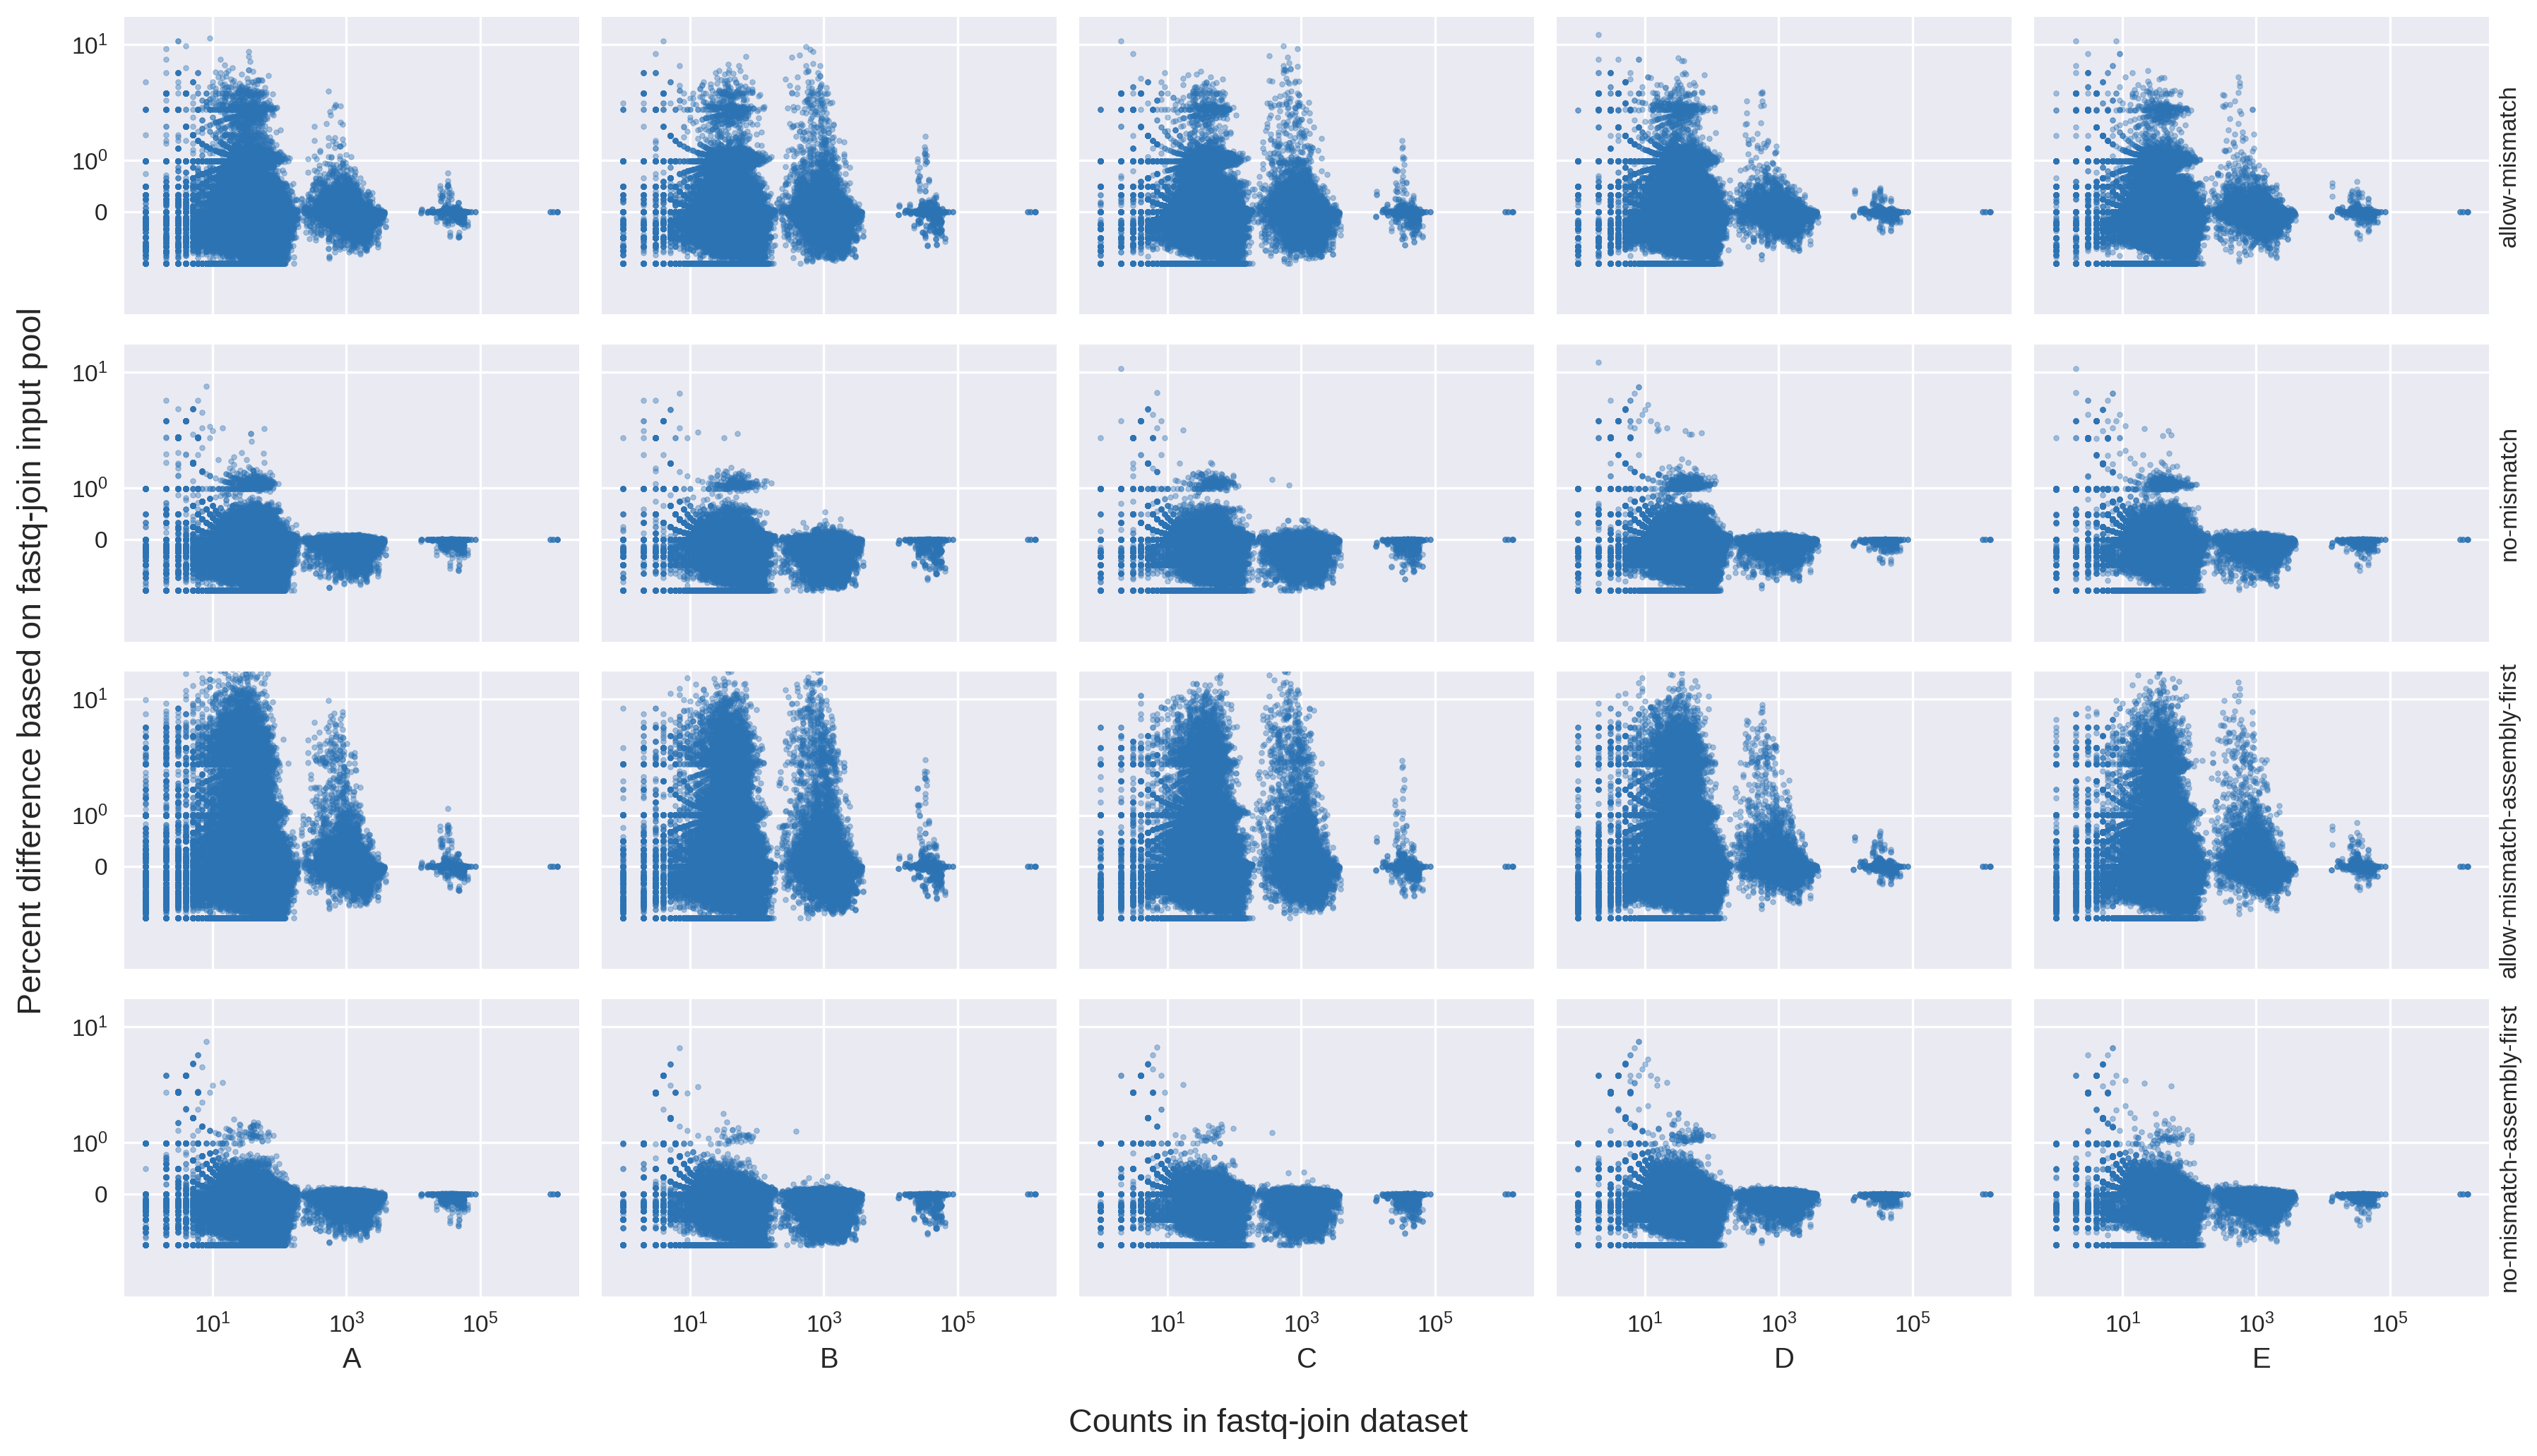

In [151]:
sample_list = [['A1', 'A2', 'A3'],
               ['B1', 'B2', 'B3'],
               ['C1', 'C2', 'C3'],
               ['D1', 'D2', 'D3'],
               ['E1', 'E2', 'E3']]

fig, axes = plt.subplots(4, 5, figsize=(18, 10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.1, wspace=0.05)

for ax_row, method in zip(axes, methods[1:]):
    common_seq = base_seq_table.index[base_seq_table.index.isin(compared_table[method].index)]
    common_seq_counts = np.expand_dims(base_counts[common_seq].sparse.to_dense().values, axis=-1)
    common_seq_counts = np.repeat(common_seq_counts, repeats=3, axis=1).reshape(-1)
    pct_diff = compared_table[method].reindex(common_seq) / base_seq_table.reindex(common_seq) - 1
    for ax, samples in zip(ax_row, sample_list):
        p = pct_diff[samples].values.reshape(-1)
        mask = ~(np.isnan(p) | np.isinf(p) | np.isneginf(p))
        ax.scatter(common_seq_counts[mask], p[mask], 
                   color='#2C73B4', alpha=0.4, s=5)
        ax.set_yscale('symlog')
        ax.set_xscale('log')
        ax.set_ylim([-2, 20])
    ax_right = ax_row[-1].twinx()
    ax_right.set_ylabel(method, fontsize=10)
    ax_right.set_yticks([])
    ax_right.set_yticklabels([])
    
for ax, samples in zip(ax_row, sample_list):
    ax.set_xlabel(samples[0][0], fontsize=12)

fig.text(s='Percent difference based on fastq-join input pool', x=0.1, y=0.5,
         ha='right', va='center', fontsize=14, rotation=90)
fig.text(s='Counts in fastq-join dataset', x=0.5, y=0.05,
         ha='center', va='center', fontsize=14)
plt.show()

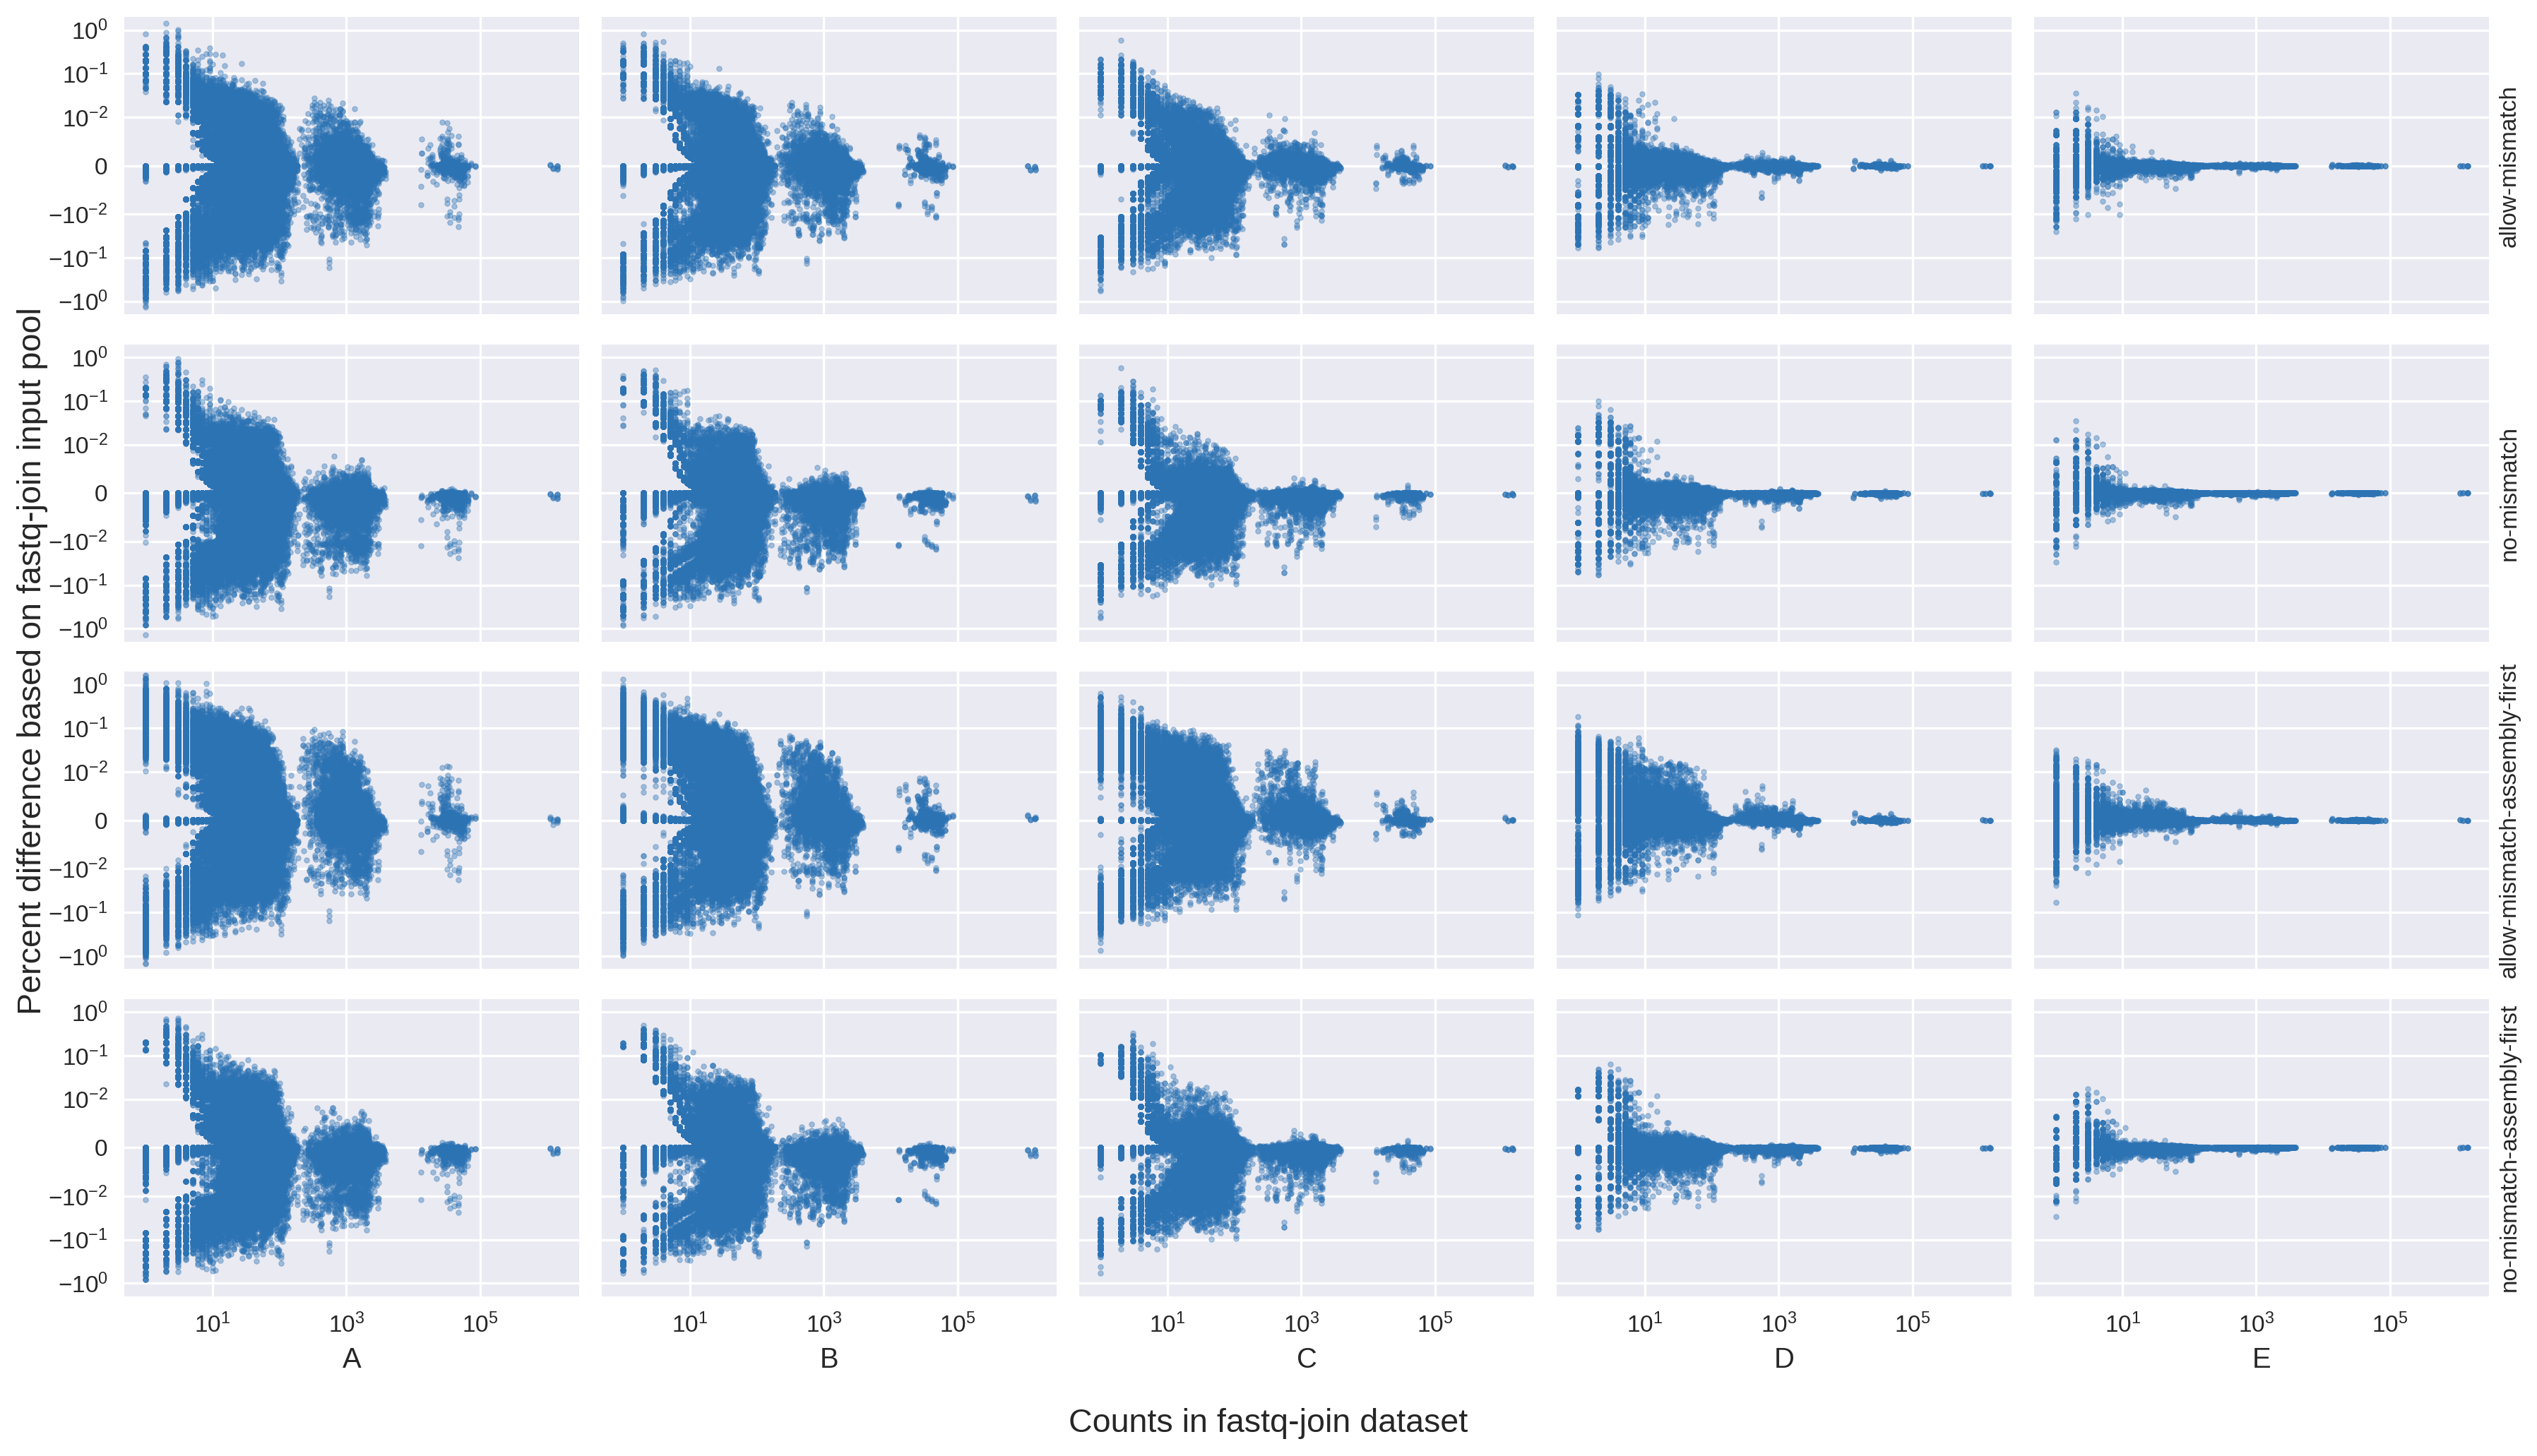

In [10]:
sample_list = [['A1', 'A2', 'A3'],
               ['B1', 'B2', 'B3'],
               ['C1', 'C2', 'C3'],
               ['D1', 'D2', 'D3'],
               ['E1', 'E2', 'E3']]

fig, axes = plt.subplots(4, 5, figsize=(18, 10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.1, wspace=0.05)

for ax_row, method in zip(axes, methods[1:]):
    common_seq = base_seq_table.index[base_seq_table.index.isin(compared_table[method].index)]
    common_seq_counts = np.expand_dims(base_counts[common_seq].sparse.to_dense().values, axis=-1)
    common_seq_counts = np.repeat(common_seq_counts, repeats=3, axis=1).reshape(-1)
    pct_diff = compared_table[method].reindex(common_seq) - base_seq_table.reindex(common_seq)
    for ax, samples in zip(ax_row, sample_list):
        p = pct_diff[samples].values.reshape(-1)
        mask = ~(np.isnan(p) | np.isinf(p) | np.isneginf(p))
        ax.scatter(common_seq_counts[mask], p[mask], 
                   color='#2C73B4', alpha=0.4, s=5)
        ax.set_yscale('symlog', linthreshy=1e-2)
        ax.set_xscale('log')
        ax.set_ylim([-2, 2])
        ax.set_yticks([-1, -0.1, -0.01, 0, 0.01, 0.1, 1])
    ax_right = ax_row[-1].twinx()
    ax_right.set_ylabel(method, fontsize=10)
    ax_right.set_yticks([])
    ax_right.set_yticklabels([])
    
for ax, samples in zip(ax_row, sample_list):
    ax.set_xlabel(samples[0][0], fontsize=12)

fig.text(s='Percent difference based on fastq-join input pool', x=0.1, y=0.5,
         ha='right', va='center', fontsize=14, rotation=90)
fig.text(s='Counts in fastq-join dataset', x=0.5, y=0.05,
         ha='center', va='center', fontsize=14)
plt.show()

In [ ]:
sample_list = [['A1', 'A2', 'A3'],
               ['B1', 'B2', 'B3'],
               ['C1', 'C2', 'C3'],
               ['D1', 'D2', 'D3'],
               ['E1', 'E2', 'E3']]

fig, axes = plt.subplots(4, 5, figsize=(18, 10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.1, wspace=0.05)

for ax_row, method in zip(axes, methods[1:]):
    common_seq = base_seq_table.index[base_seq_table.index.isin(compared_table[method].index)]
    common_seq_counts = np.expand_dims(base_counts[common_seq].sparse.to_dense().values, axis=-1)
    common_seq_counts = np.repeat(common_seq_counts, repeats=3, axis=1).reshape(-1)
    pct_diff = compared_table[method].reindex(common_seq) - base_seq_table.reindex(common_seq)
    for ax, samples in zip(ax_row, sample_list):
        p = pct_diff[samples].values.reshape(-1)
        mask = ~(np.isnan(p) | np.isinf(p) | np.isneginf(p))
        ax.scatter(common_seq_counts[mask], p[mask], 
                   color='#2C73B4', alpha=0.4, s=5)
#         ax.set_yscale('symlog')
        ax.set_xscale('log')
        ax.set_ylim([-2, 2])
    ax_right = ax_row[-1].twinx()
    ax_right.set_ylabel(method, fontsize=10)
    ax_right.set_yticks([])
    ax_right.set_yticklabels([])
    
for ax, samples in zip(ax_row, sample_list):
    ax.set_xlabel(samples[0][0], fontsize=12)

fig.text(s='Percent difference based on fastq-join input pool', x=0.1, y=0.5,
         ha='right', va='center', fontsize=14, rotation=90)
fig.text(s='Counts in fastq-join dataset', x=0.5, y=0.05,
         ha='center', va='center', fontsize=14)
plt.show()